# Combined Preprocessing for Apple Stock Dataset with Seasonal Features

This notebook preprocesses the Apple stock dataset (`apple_stock_dataset.csv`) for time series forecasting, creating a clean and generalized dataset suitable for LSTM, ARIMA, SARIMA, and Prophet models. It combines the best features from two preprocessing scripts, including robust data cleaning, comprehensive feature engineering (with seasonal features, manual RSI, returns, and moving averages), outlier detection, and scaling. It avoids model-specific transformations like stationarity checks or sequence creation to ensure flexibility. The output is a preprocessed CSV file shareable with the group, with visualizations to inspect trends and seasonality.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import pickle

In [2]:

# Step 1: Load and inspect the data
df = pd.read_csv('datasets/apple_stock_dataset.csv', parse_dates=['Date'])
print('Dataset Info:')
print(df.info())
print('\nFirst 5 rows:')
print(df.head())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11084 entries, 0 to 11083
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    11084 non-null  object 
 1   Open    11084 non-null  float64
 2   High    11084 non-null  float64
 3   Low     11084 non-null  float64
 4   Close   11084 non-null  float64
 5   Volume  11084 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 519.7+ KB
None

First 5 rows:
                        Date      Open      High       Low     Close  \
0  1980-12-12 00:00:00-05:00  0.098834  0.099264  0.098834  0.098834   
1  1980-12-15 00:00:00-05:00  0.094108  0.094108  0.093678  0.093678   
2  1980-12-16 00:00:00-05:00  0.087232  0.087232  0.086802  0.086802   
3  1980-12-17 00:00:00-05:00  0.088951  0.089381  0.088951  0.088951   
4  1980-12-18 00:00:00-05:00  0.091530  0.091959  0.091530  0.091530   

      Volume  
0  469033600  
1  175884800  
2  105728000  
3   8

In [3]:

# Step 2: Handle missing values and anomalies
print('\nMissing Values:')
print(df.isna().sum())
# Forward fill, backward fill, and interpolate
df_numeric = df.select_dtypes(include=[np.number])  # only numeric columns
df[df_numeric.columns] = df_numeric.ffill().bfill().interpolate(method='linear')
# Replace zero volume with mean volume
df.loc[df['Volume'] == 0, 'Volume'] = int(df['Volume'].mean())



Missing Values:
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [4]:
# Step 3: Set Date as index

df['Date'] = pd.to_datetime(df['Date'], utc=True, errors='coerce').dt.tz_convert(None)
df.set_index('Date', inplace=True)

In [5]:
# Step 4: Check for data continuity
print('\nDuplicate Dates:', df.index.duplicated().sum())
df = df[~df.index.duplicated(keep='first')]  # Remove duplicates if any


Duplicate Dates: 0


In [6]:

# Step 5: Feature selection
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]


In [7]:

# Step 6: Feature engineering
# Lagged features
df['Close_Lag1'] = df['Close'].shift(1)
df['Close_Lag2'] = df['Close'].shift(2)
# Moving averages
df['MA7'] = df['Close'].rolling(window=7).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()
# Returns
df['Return'] = df['Close'].pct_change()
df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))


In [8]:

# Manual RSI calculation (14-day period)
def calculate_rsi(data, period=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
df['RSI'] = calculate_rsi(df, period=14)


In [9]:
# Seasonal features
df['Day_of_Week'] = df.index.dayofweek  # 0=Monday, 4=Friday
df['Month'] = df.index.month  # 1=January, 12=December
df['Quarter'] = df.index.quarter  # 1=Q1, 4=Q4
df['Year'] = df.index.year
# Outlier detection for returns
return_mean = df['Return'].mean()
return_std = df['Return'].std()
outlier_cutoff = 3 * return_std
df['Return_Outlier'] = ((df['Return'] - return_mean).abs() > outlier_cutoff)
# Drop rows with NaN from feature engineering
df = df.dropna()


In [10]:

# Step 7: Normalize/scale features (for LSTM)
scaler = MinMaxScaler()
numerical_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Close_Lag1', 'Close_Lag2', 'MA7', 'MA20', 'MA50', 'Return', 'LogReturn', 'RSI']
scaled_data = scaler.fit_transform(df[numerical_columns])
scaled_df = pd.DataFrame(scaled_data, columns=[f'{col}_Scaled' for col in numerical_columns], index=df.index)
# Scale seasonal features separately
seasonal_scaler = MinMaxScaler()
seasonal_columns = ['Day_of_Week', 'Month', 'Quarter']
seasonal_scaled = seasonal_scaler.fit_transform(df[seasonal_columns])
seasonal_scaled_df = pd.DataFrame(seasonal_scaled, columns=[f'{col}_Scaled' for col in seasonal_columns], index=df.index)
# Combine original and scaled features
df = pd.concat([df, scaled_df, seasonal_scaled_df], axis=1)


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11035 entries, 1981-02-24 05:00:00 to 2024-11-29 05:00:00
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Open                11035 non-null  float64
 1   High                11035 non-null  float64
 2   Low                 11035 non-null  float64
 3   Close               11035 non-null  float64
 4   Volume              11035 non-null  int64  
 5   Close_Lag1          11035 non-null  float64
 6   Close_Lag2          11035 non-null  float64
 7   MA7                 11035 non-null  float64
 8   MA20                11035 non-null  float64
 9   MA50                11035 non-null  float64
 10  Return              11035 non-null  float64
 11  LogReturn           11035 non-null  float64
 12  RSI                 11035 non-null  float64
 13  Day_of_Week         11035 non-null  int32  
 14  Month               11035 non-null  int32  
 15  Quarter           

In [24]:
with open('scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
with open('seasonal_scaler.pkl', 'wb') as f:
        pickle.dump(seasonal_scaler, f)
close_scaler = MinMaxScaler()
close_scaler.fit(df[['Close']])
with open('close_scaler.pkl', 'wb') as f:
    pickle.dump(close_scaler, f)

In [13]:

# Step 8: Train-test split
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]
print('\nTrain size:', len(train), 'Test size:', len(test))



Train size: 8828 Test size: 2207


In [14]:

# Step 8: Save preprocessed data
df.to_csv('preprocessed_apple_stock.csv')
train.to_csv('preprocessed_apple_stock_train.csv')
test.to_csv('preprocessed_apple_stock_test.csv')
print('\nPreprocessed data saved as: preprocessed_apple_stock.csv, preprocessed_apple_stock_train.csv, preprocessed_apple_stock_test.csv')



Preprocessed data saved as: preprocessed_apple_stock.csv, preprocessed_apple_stock_train.csv, preprocessed_apple_stock_test.csv


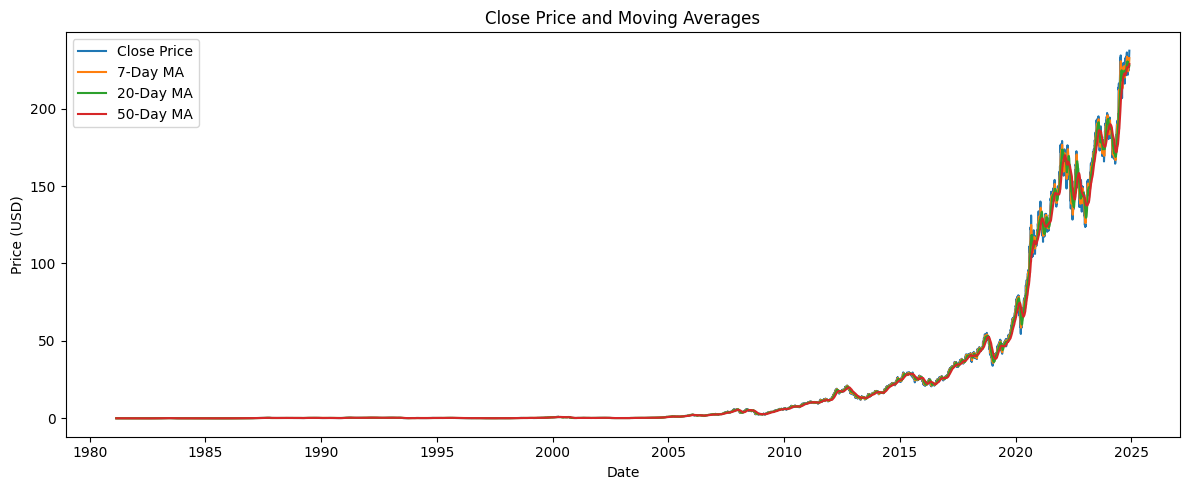

In [15]:

# Step 9: Visualizations
# A. Close price with moving averages
plt.figure(figsize=(12, 5))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['MA7'], label='7-Day MA')
plt.plot(df['MA20'], label='20-Day MA')
plt.plot(df['MA50'], label='50-Day MA')
plt.title('Close Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()


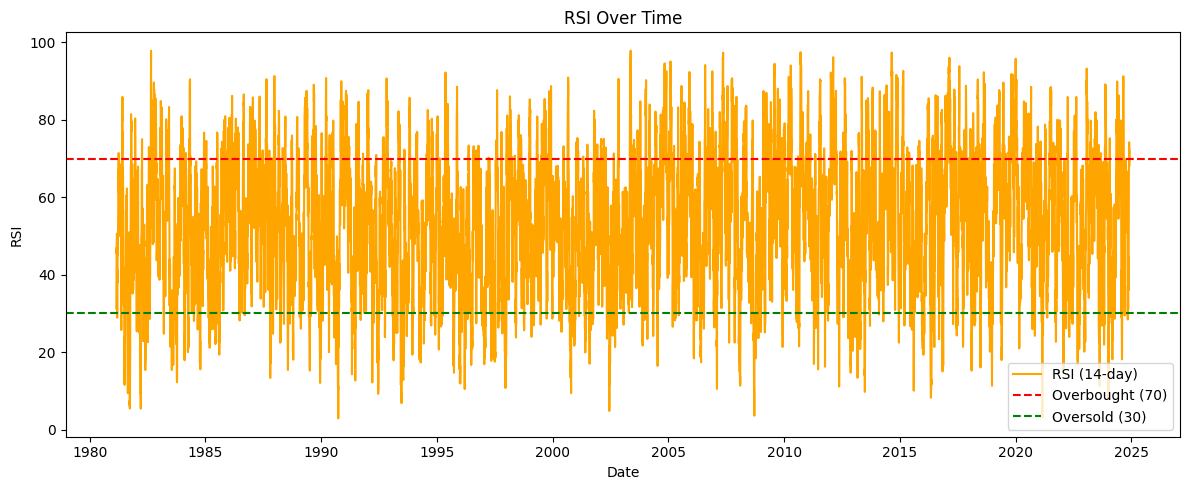

In [16]:

# B. RSI
plt.figure(figsize=(12, 5))
plt.plot(df['RSI'], label='RSI (14-day)', color='orange')
plt.title('RSI Over Time')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.axhline(y=70, color='r', linestyle='--', label='Overbought (70)')
plt.axhline(y=30, color='g', linestyle='--', label='Oversold (30)')
plt.legend()
plt.tight_layout()
plt.show()


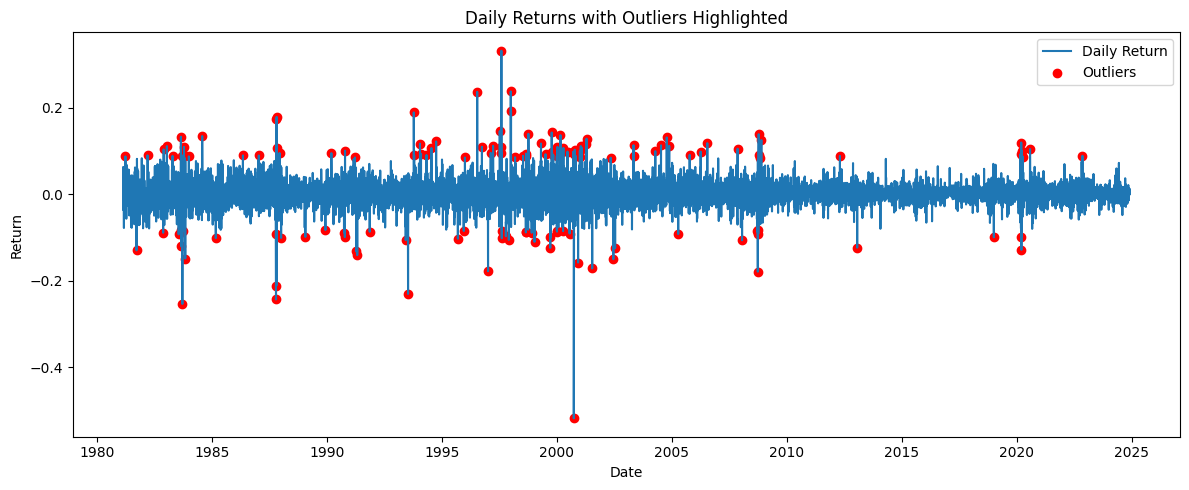

In [17]:

# C. Daily returns with outliers
plt.figure(figsize=(12, 5))
plt.plot(df['Return'], label='Daily Return')
plt.scatter(df.index[df['Return_Outlier']], df.loc[df['Return_Outlier'], 'Return'], color='red', label='Outliers')
plt.title('Daily Returns with Outliers Highlighted')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.tight_layout()
plt.show()


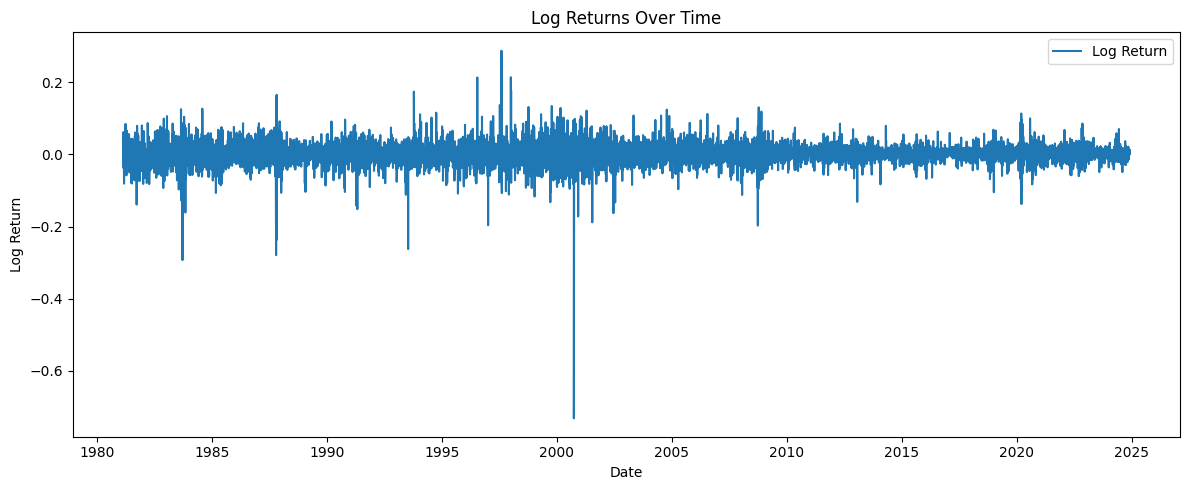

In [18]:

# D. Log returns
plt.figure(figsize=(12, 5))
plt.plot(df['LogReturn'], label='Log Return')
plt.title('Log Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.tight_layout()
plt.show()


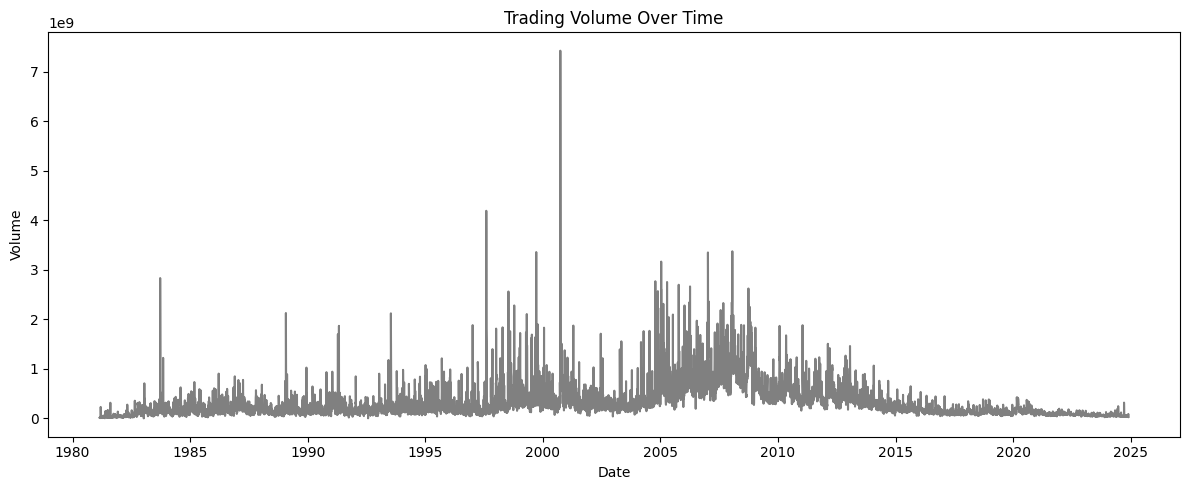

In [19]:

# E. Trading volume
plt.figure(figsize=(12, 5))
plt.plot(df['Volume'], color='gray')
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.tight_layout()
plt.show()


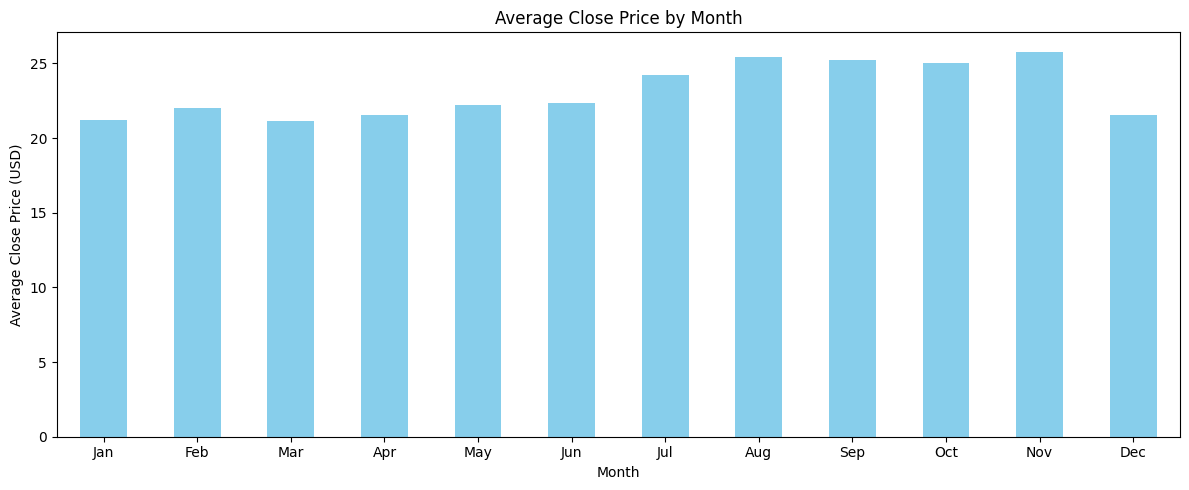

In [20]:

# F. Seasonal patterns (monthly and weekly averages)
monthly_avg = df.groupby('Month')['Close'].mean()
plt.figure(figsize=(12, 5))
monthly_avg.plot(kind='bar', color='skyblue')
plt.title('Average Close Price by Month')
plt.xlabel('Month')
plt.ylabel('Average Close Price (USD)')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.tight_layout()
plt.show()


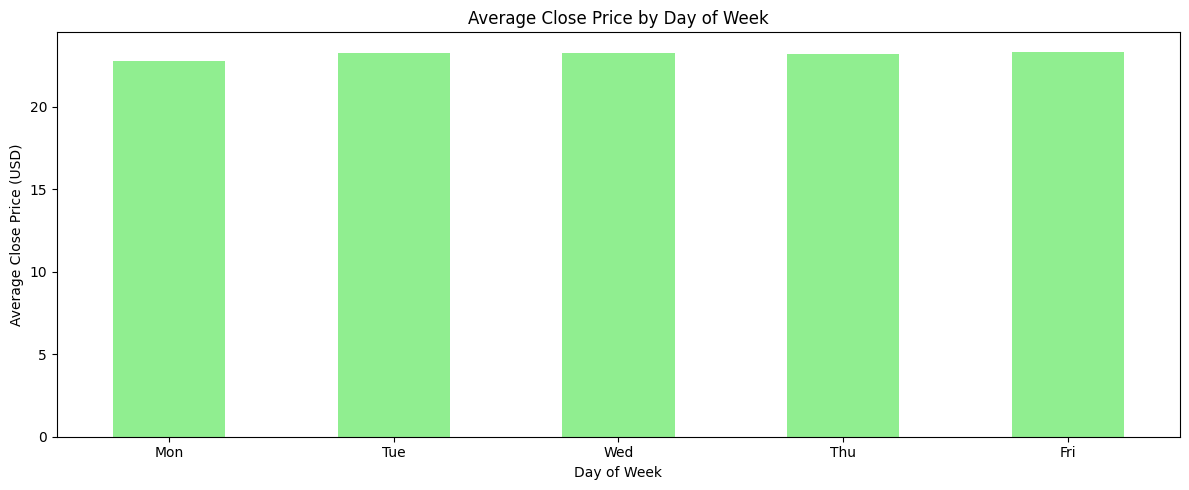

In [21]:

weekly_avg = df.groupby('Day_of_Week')['Close'].mean()
plt.figure(figsize=(12, 5))
weekly_avg.plot(kind='bar', color='lightgreen')
plt.title('Average Close Price by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Close Price (USD)')
plt.xticks(ticks=range(5), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri'], rotation=0)
plt.tight_layout()
plt.show()


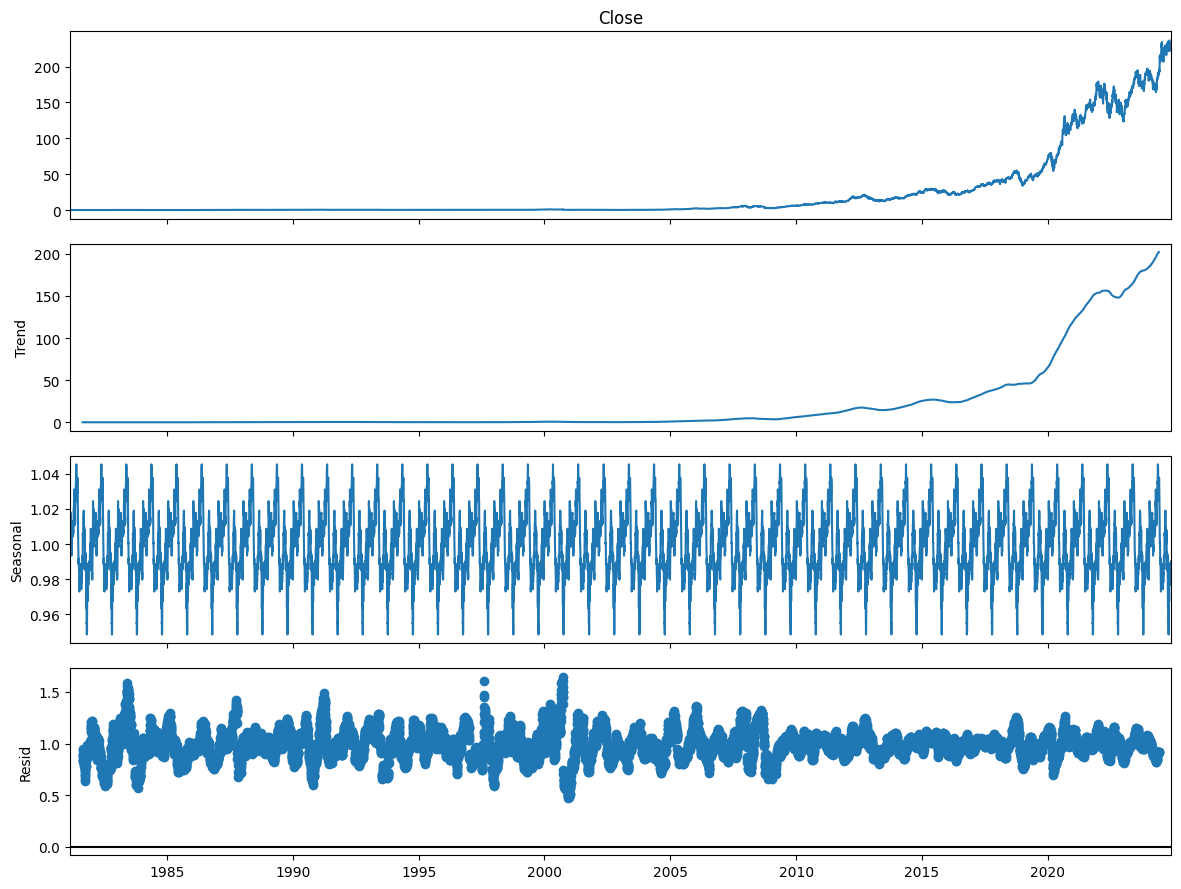

In [22]:

# G. Seasonal decomposition (252-day period, approximately one trading year)
decomp = seasonal_decompose(df['Close'], model='multiplicative', period=252)
fig = decomp.plot()
fig.set_size_inches(12, 9)
plt.tight_layout()
plt.show()


In [23]:

# Step 10: Final check
print('Preprocessed DataFrame head:')
print(df.head())
print(f'\nNumber of daily return outliers detected: {df["Return_Outlier"].sum()}')

Preprocessed DataFrame head:
                         Open      High       Low     Close    Volume  \
Date                                                                    
1981-02-24 05:00:00  0.082506  0.082506  0.081646  0.081646  16979200   
1981-02-25 05:00:00  0.086802  0.087232  0.086802  0.086802  19488000   
1981-02-26 05:00:00  0.088091  0.088521  0.088091  0.088091  10841600   
1981-02-27 05:00:00  0.091100  0.091959  0.091100  0.091100  14761600   
1981-03-02 05:00:00  0.091530  0.091959  0.091530  0.091530  11760000   

                     Close_Lag1  Close_Lag2       MA7      MA20      MA50  \
Date                                                                        
1981-02-24 05:00:00    0.084654    0.083365  0.086987  0.093764  0.102092   
1981-02-25 05:00:00    0.081646    0.084654  0.086864  0.092604  0.101851   
1981-02-26 05:00:00    0.086802    0.081646  0.086618  0.091680  0.101739   
1981-02-27 05:00:00    0.088091    0.086802  0.086250  0.091100  0.101825 

## Notes
- **Input**: Assumes `apple_stock_dataset.csv` is in the same directory.
- **Output**: Saves `preprocessed_apple_stock_combined.csv` (full dataset), `preprocessed_apple_stock_train.csv` (training set), and `preprocessed_apple_stock_test.csv` (test set).
- **Features**: Includes original columns (`Open`, `High`, `Low`, `Close`, `Volume`), engineered features (`Close_Lag1`, `Close_Lag2`, `MA7`, `MA20`, `MA50`, `Return`, `LogReturn`, `RSI`, `Return_Outlier`), seasonal features (`Day_of_Week`, `Month`, `Quarter`, `Year`), and scaled versions (e.g., `Close_Scaled`, `Day_of_Week_Scaled`).
- **RSI Calculation**: Computed manually using Pandas, avoiding TA-Lib.
- **Seasonal Features**: `Day_of_Week` (0=Monday, 4=Friday), `Month` (1=January, 12=December), `Quarter` (1=Q1, 4=Q4), and `Year` capture weekly, monthly, quarterly, and yearly patterns.
- **Outlier Detection**: Flags outliers in `Return` using a 3-standard-deviation threshold.
- **Flexibility**: Suitable for:
  - **LSTM**: Use scaled features (e.g., `Close_Scaled`, `RSI_Scaled`, `Day_of_Week_Scaled`) and add sequence creation.
  - **ARIMA/SARIMA**: Use `Close`, `Return`, or `LogReturn` with seasonal features; apply stationarity checks.
  - **Prophet**: Rename `Date` to `ds` and `Close` to `y`, use seasonal features as regressors.
- **Dependencies**: Install `pandas`, `numpy`, `scikit-learn`, `statsmodels`, `matplotlib` via `pip`.
- **Visualizations**: Comprehensive plots for `Close`, moving averages, RSI, returns, outliers, volume, seasonal patterns, and decomposition.